In [2]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from datetime import datetime
import datetime
import time
import timestring

Bring all the data into a single dataframe.
Sample of the data is located in the Google Drive folder (link below). One zip file for each month for the year of 2017
https://drive.google.com/drive/folders/1lZJhPM24i9PQRW_nOTQj5sQy3FTiwhbY?usp=sharing


In [8]:
path = './Data/AirlineData/2017/'
all_files = glob.glob(os.path.join(path, "*.zip"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, compression='zip', parse_dates=['FL_DATE']) for f in all_files)
concatenated_df = pd.concat(df_from_each_file)

In [9]:
concatenated_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5674621 entries, 0 to 410516
Data columns (total 33 columns):
YEAR                   int64
MONTH                  int64
DAY_OF_MONTH           int64
DAY_OF_WEEK            int64
FL_DATE                datetime64[ns]
OP_CARRIER             object
ORIGIN                 object
ORIGIN_CITY_NAME       object
ORIGIN_STATE_ABR       object
DEST                   object
DEST_CITY_NAME         object
DEST_STATE_ABR         object
CRS_DEP_TIME           int64
DEP_TIME               float64
DEP_DELAY              float64
DEP_DELAY_NEW          float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME           int64
ARR_TIME               float64
ARR_DELAY              float64
ARR_DELAY_NEW          float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
N

In [10]:
#define a function to find memory usage 
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

# Get all the int-type data

In [11]:
df_int = concatenated_df.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

303.06 MB
92.00 MB


# Get all the float-type data

In [12]:
df_float = concatenated_df.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

865.88 MB
454.59 MB


# Create an optimized copy of df

In [13]:
optimized_df = concatenated_df.copy()

optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

print(mem_usage(concatenated_df))
print(mem_usage(optimized_df))

3533.38 MB
2911.03 MB


# Get all the object-type data

In [14]:
df_obj = concatenated_df.select_dtypes(include=['object']).copy()

In [15]:
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]
        
print(mem_usage(df_obj))
print(mem_usage(converted_obj))

2407.74 MB
102.95 MB


In [16]:
optimized_df[converted_obj.columns] = converted_obj
mem_usage(optimized_df)

'606.25 MB'

In [17]:
optimized_df.columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_CARRIER',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 32'],
      dtype='object')

# Clean up the data

In [18]:
optimized_df = optimized_df.drop(['Unnamed: 32'], axis=1)

In [19]:
#remove rows will null values which is approximately 1.5%
null_columns = optimized_df.columns[optimized_df.isnull().any()]
optimized_df[null_columns].isnull().sum()

DEP_TIME                 80308
DEP_DELAY                80343
DEP_DELAY_NEW            80343
TAXI_OUT                 82145
WHEELS_OFF               82141
WHEELS_ON                84674
TAXI_IN                  84674
ARR_TIME                 84674
ARR_DELAY                95211
ARR_DELAY_NEW            95211
ACTUAL_ELAPSED_TIME      95211
AIR_TIME                 95211
CARRIER_DELAY          4645148
WEATHER_DELAY          4645148
NAS_DELAY              4645148
SECURITY_DELAY         4645148
LATE_AIRCRAFT_DELAY    4645148
dtype: int64

In [20]:
optimized_df = optimized_df.dropna(subset=['DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME'])

# Creating a new column with departure date and time

In [41]:
#since the DEP_TIME is presented as a float we need to convert it to a Timestamp
def convert_to_time (datatype):
    '''This method will take a float as input and returns a datetime.time object'''
    to_string = str(int(datatype))
    #check length of string and add leading zeros if lenght is less than 4
    while len(to_string) < 4:
        to_string = '0' + to_string
    #check if hour starts with 24 then change to 00
    if to_string[:2] == '24':
        to_string = '00' + to_string[2:]
    obj = time.strptime(to_string, '%H%M')
    
    #to_string = to_string[:2] + ':' + to_string[2:] 
    #datetime = pd.to_datetime(to_string)
    #datetime = pd.to_datetime(to_string, format='%H:%M')
    #time = datetime.time()
    #return time
    
    datetime = time.strftime("%H:%M", obj)
    return datetime

In [42]:
#Apply the method to the DEP_TIME column to convert it to a Timestamp
optimized_df['DEP_TIME_TIME'] = optimized_df.DEP_TIME.apply(convert_to_time)

In [21]:
#We now need to create a new Timestamp column incorporating the information from FL_DATE and DEP_TIME
def combine_datetime (dataframe):
    '''This function will extract needed data from two columns and combine into a single Timestamp object'''
    year = dataframe[0].year
    month = dataframe[0].month
    day = dataframe[0].day
    hour = dataframe[1].hour
    minute = dataframe[1].minute
    second = dataframe[1].second
    
    datetime = pd.Timestamp(year, month, day, hour, minute, second)
    return datetime

In [22]:
combined = optimized_df[['FL_DATE','DEP_TIME']]

In [23]:
combined.head()

,FL_DATE,DEP_TIME
0,2017-03-21,2019-03-30 10:31:00
1,2017-03-21,2019-03-30 14:20:00
2,2017-03-21,2019-03-30 12:03:00
3,2017-03-21,2019-03-30 07:58:00
4,2017-03-21,2019-03-30 10:41:00


In [24]:
#apply the combine_datetime function to optimized_df and create a new column 'FL_TIME'
optimized_df['FL_TIME'] = combined.apply(combine_datetime, axis=1)

In [104]:
def time_to_float(time):
    '''This function will convert time that is incorrectly represented into a float
    for easier plotting with matplotlib'''
    if len(str(int(time))) > 2:
        denom = time / 2400.0
        numer = (float(str(int(time))[:-2:]) + float(str(int(time))[-2:])/60)/24
        ratio = numer / denom
        time_float = time * ratio
    else:
        time_float = time / 60 * 100
    
    return time_float

# Import two more csv files for reference

In [129]:
#Airport location for geographical analysis
airport_location = pd.read_csv('airport_loc.csv')

In [130]:
airport_location.head()

,locationID,Latitude,Longitude
0,ADK,51.8781,176.6461
1,AKK,56.9386,154.1825
2,Z13,60.9047,161.4225
3,AKI,60.9028,161.2306
4,AUK,62.6800,164.6600


In [131]:
#combine Latitude and Longitude into a tuple and form a new column and drop the Latitude & Longitude columns
airport_location['location'] = list(zip(airport_location.Latitude, airport_location.Longitude))
airport_location.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
airport_location.head(3)

,locationID,location
0,ADK,"(51.8781, 176.6461)"
1,AKK,"(56.9386, 154.1825)"
2,Z13,"(60.9047, 161.4225)"


In [133]:
airport_loc = airport_location.set_index('locationID').to_dict()
airport_loc = airport_loc['location']

In [251]:
airport_loc.get('JFK')

(40.6397, 73.7789)

In [136]:
#Airline codes with names for cleaner presentation
airline_codes = pd.read_csv('L_CARRIER_HISTORY.csv')

In [137]:
airline_codes.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


In [138]:
airline_dict = airline_codes.set_index('Code').to_dict()

In [139]:
airline_dict = airline_dict['Description']

In [250]:
airline_dict.get('WN')

'Southwest Airlines Co. '

# Top three busiest airports by number of flights per year

In [234]:
optimized_df.ORIGIN.value_counts().head()

ATL    358537
ORD    262074
DEN    221148
LAX    211730
DFW    178967
Name: ORIGIN, dtype: int64

In [235]:
top_three = optimized_df[(optimized_df.ORIGIN == 'ATL') | (optimized_df.ORIGIN == 'ORD') |
                         (optimized_df.ORIGIN == 'DEN')]

In [239]:
top_three['ORIGIN'].unique()

[DEN, ORD, ATL]
Categories (3, object): [DEN, ORD, ATL]

In [241]:
top_three.groupby('ORIGIN').size()

ORIGIN
ABE         0
ABI         0
ABQ         0
ABR         0
ABY         0
ACK         0
ACT         0
ACV         0
ACY         0
ADK         0
ADQ         0
AEX         0
AGS         0
AKN         0
ALB         0
ALO         0
AMA         0
ANC         0
APN         0
ASE         0
ATL    358537
ATW         0
AUS         0
AVL         0
AVP         0
AZO         0
BDL         0
BET         0
BFL         0
BGM         0
        ...  
STS         0
STT         0
STX         0
SUN         0
SUX         0
SWF         0
SWO         0
SYR         0
TKI         0
TLH         0
TOL         0
TPA         0
TRI         0
TTN         0
TUL         0
TUS         0
TVC         0
TWF         0
TXK         0
TYR         0
TYS         0
UIN         0
UST         0
VLD         0
VPS         0
WRG         0
WYS         0
XNA         0
YAK         0
YUM         0
Length: 320, dtype: int64

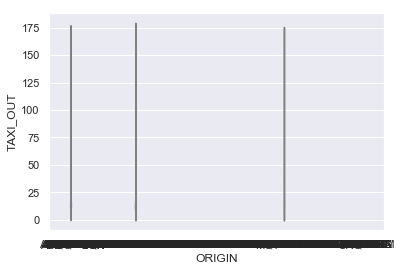

In [240]:
sns.violinplot(x=top_three.ORIGIN, y=top_three.TAXI_OUT, data=top_three, inner=None, color='lightgray')

# Overlay a strip plot on the violin plot
#sns.stripplot(x=top_three.ORIGIN, y=top_three.TAXI_OUT, data=top_three, jitter=True, size=1.5)

# Display the plot
plt.show()

# EDA

## Most popular route in United States (by number of flights) SFO to LAX

In [208]:
#Let's find the most popular route in the US (the most flights per year between any two cities.)
optimized_df.groupby(['ORIGIN','DEST']).size().sort_values(ascending=False).head()

ORIGIN  DEST
SFO     LAX     15243
LAX     SFO     15032
        JFK     12607
JFK     LAX     12604
LAS     LAX     10970
dtype: int64

In [28]:
#Create a dataframe with the most popular route 
#This has all the flights, delayed and normal
#We need to split this into two dataframes: flights that are delayed and flights that are not
popular_route = optimized_df[(optimized_df.ORIGIN == 'SFO') & (optimized_df.DEST == 'LAX')]

In [164]:
popular_route.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,...,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DEP_TIME_SCALE,ARR_TIME_SCALE
10282,2017,3,1,3,2017-03-01,OO,SFO,"San Francisco, CA",CA,LAX,...,82.0,55.0,337.0,NaN,NaN,NaN,NaN,NaN,680.000000,816.666667
10284,2017,3,1,3,2017-03-01,OO,SFO,"San Francisco, CA",CA,LAX,...,106.0,58.0,337.0,NaN,NaN,NaN,NaN,NaN,783.333333,960.000000
10286,2017,3,1,3,2017-03-01,OO,SFO,"San Francisco, CA",CA,LAX,...,109.0,57.0,337.0,NaN,NaN,NaN,NaN,NaN,870.000000,1051.666667
10288,2017,3,1,3,2017-03-01,OO,SFO,"San Francisco, CA",CA,LAX,...,87.0,57.0,337.0,NaN,NaN,NaN,NaN,NaN,978.333333,1123.333333
10290,2017,3,1,3,2017-03-01,OO,SFO,"San Francisco, CA",CA,LAX,...,86.0,61.0,337.0,NaN,NaN,NaN,NaN,NaN,1078.333333,1221.666667


In [86]:
popular_route['DEP_TIME_SCALE'] = popular_route.DEP_TIME.apply(time_to_float)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [91]:
popular_route['ARR_TIME_SCALE'] = popular_route.ARR_TIME.apply(time_to_float)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
popular_route.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15243 entries, 10282 to 410469
Data columns (total 32 columns):
YEAR                   15243 non-null uint16
MONTH                  15243 non-null uint8
DAY_OF_MONTH           15243 non-null uint8
DAY_OF_WEEK            15243 non-null uint8
FL_DATE                15243 non-null datetime64[ns]
OP_CARRIER             15243 non-null category
ORIGIN                 15243 non-null category
ORIGIN_CITY_NAME       15243 non-null category
ORIGIN_STATE_ABR       15243 non-null category
DEST                   15243 non-null category
DEST_CITY_NAME         15243 non-null category
DEST_STATE_ABR         15243 non-null category
CRS_DEP_TIME           15243 non-null uint16
DEP_TIME               15243 non-null float32
DEP_DELAY              15243 non-null float32
DEP_DELAY_NEW          15243 non-null float32
TAXI_OUT               15243 non-null float32
WHEELS_OFF             15243 non-null float32
WHEELS_ON              15243 non-null float32
TAXI_I

In [93]:
#We need to split the popular_route dataframe into two: flights that are delayed and flights that are not
#Create a dataframe with only delayed flights of greater than 15 minutes for the most popular route
popular_route_del = popular_route[(popular_route.ARR_DELAY > 15) & (popular_route.ARR_DELAY < 180)]
#Create a dataframe with non-delayed flights
popular_route_norm = popular_route[popular_route.ARR_DELAY <= 15]

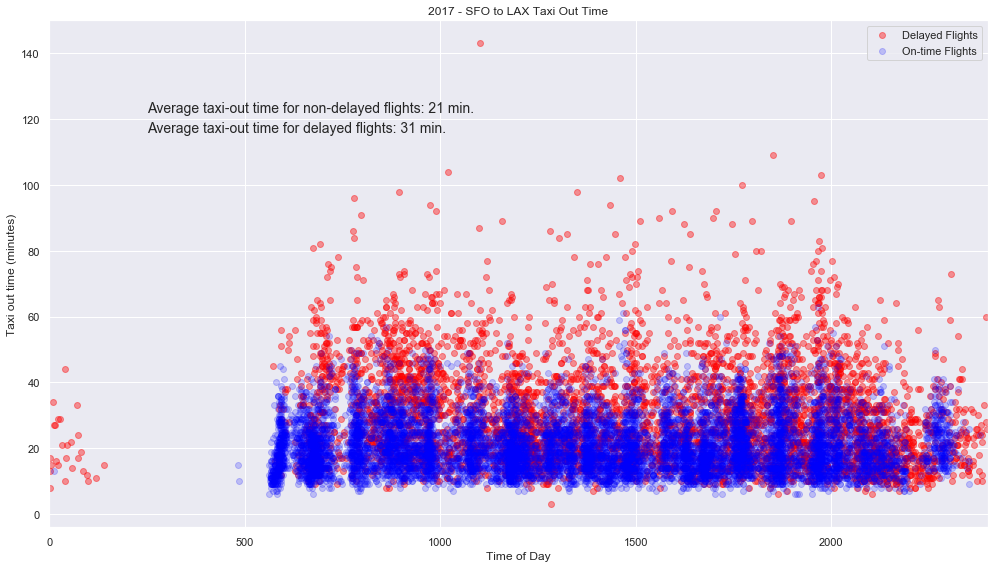

In [154]:
#The taxi out time at the destination for delayed and normal flights
x_normal = popular_route_norm.DEP_TIME_SCALE
y_normal = popular_route_norm.TAXI_OUT
x_delayed = popular_route_del.DEP_TIME_SCALE
y_delayed = popular_route_del.TAXI_OUT

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Taxi out time (minutes)')
ax.set_title('2017 - SFO to LAX Taxi Out Time')
plt.text(250, 122, f"Average taxi-out time for non-delayed flights: {round(popular_route_norm.TAXI_OUT.mean())} min.", fontsize=14)
plt.text(250, 116, f"Average taxi-out time for delayed flights: {round(popular_route_del.TAXI_OUT.mean())} min.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

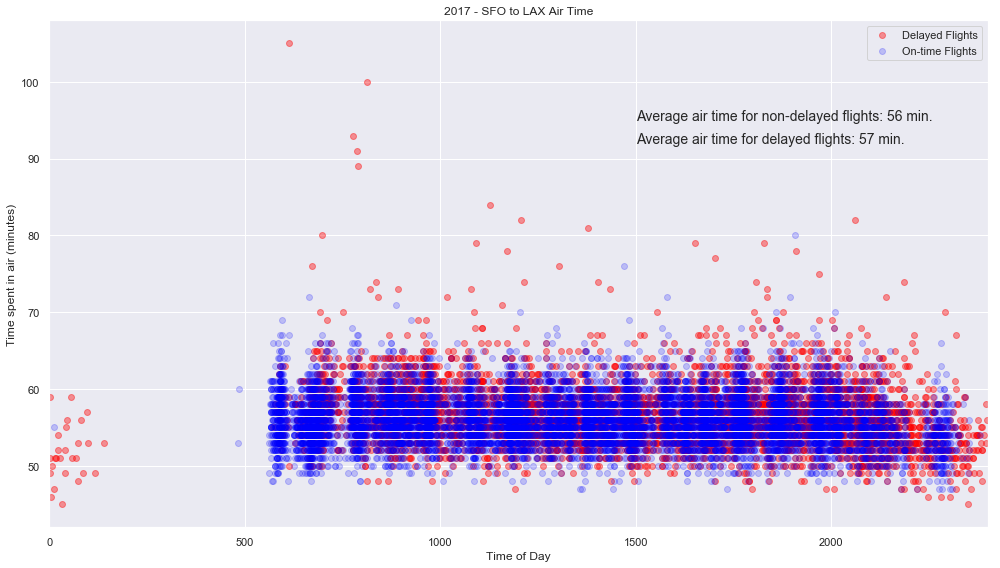

In [158]:
#Flight time for delayed and normal flights
x_normal = popular_route_norm.DEP_TIME_SCALE
y_normal = popular_route_norm.AIR_TIME
x_delayed = popular_route_del.DEP_TIME_SCALE
y_delayed = popular_route_del.AIR_TIME

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Time spent in air (minutes)')
ax.set_title('2017 - SFO to LAX Air Time')
plt.text(1500, 95, f"Average air time for non-delayed flights: {round(popular_route_norm.AIR_TIME.mean())} min.", fontsize=14)
plt.text(1500, 92, f"Average air time for delayed flights: {round(popular_route_del.AIR_TIME.mean())} min.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

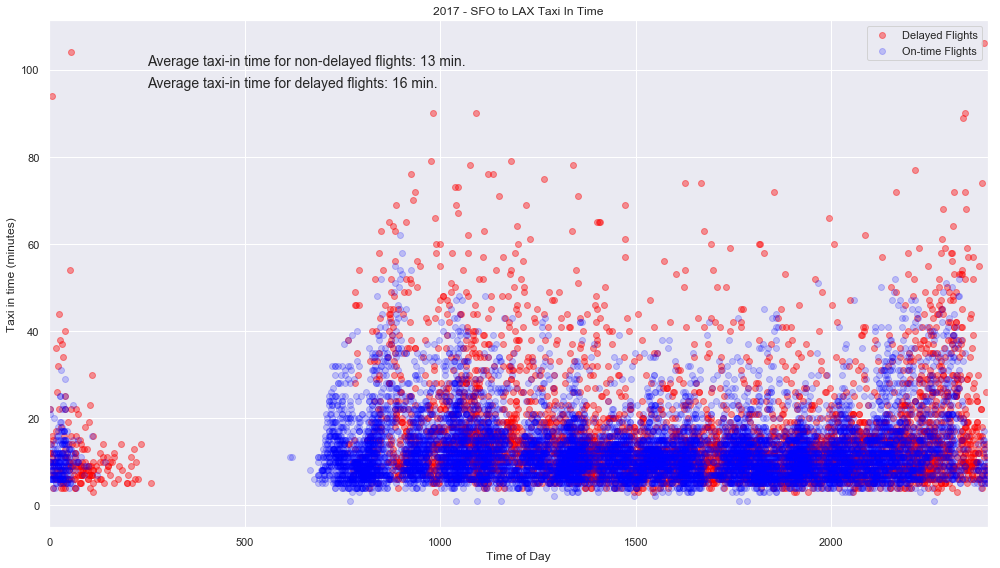

In [159]:
#And the taxi in time at the destination for delayed and normal flights
x_normal = popular_route_norm.ARR_TIME_SCALE
y_normal = popular_route_norm.TAXI_IN
x_delayed = popular_route_del.ARR_TIME_SCALE
y_delayed = popular_route_del.TAXI_IN

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Taxi in time (minutes)')
ax.set_title('2017 - SFO to LAX Taxi In Time')
plt.text(250, 101, f"Average taxi-in time for non-delayed flights: {round(popular_route_norm.TAXI_IN.mean())} min.", fontsize=14)
plt.text(250, 96, f"Average taxi-in time for delayed flights: {round(popular_route_del.TAXI_IN.mean())} min.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

In [95]:
#Computing summaries
#Total flights between the most populare cities
total_flights = optimized_df.groupby(['ORIGIN','DEST']).size().sort_values(ascending=False)[0]
delayed_flights = popular_route_del.YEAR.count()
not_delayed_flights = popular_route_norm.YEAR.count()
print(f"Total flights from SFO to LAX in 2017: {total_flights}")
print(f"Flights that are arriving late by more than 15 minutes: {delayed_flights} \
({round(delayed_flights / total_flights * 100, 1)}%)")
print(f"Flights that are arriving early or on time: {not_delayed_flights} \
({round(not_delayed_flights / total_flights * 100, 1)}%)")
print("*Remainder of flights were delayed longer than 3 hours")

Total flights from SFO to LAX in 2017: 15243
Flights that are arriving late by more than 15 minutes: 4747 (31.1%)
Flights that are arriving early or on time: 10299 (67.6%)
*Remainder of flights were delayed longer than 3 hours


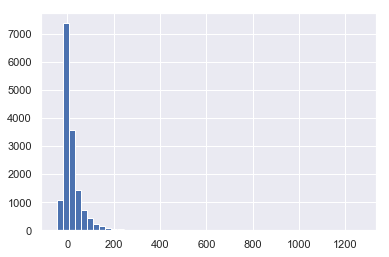

In [574]:
popular_route.ARR_DELAY.hist(bins=50)

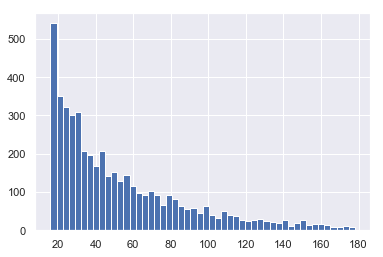

In [575]:
popular_route_del.ARR_DELAY.hist(bins=50)

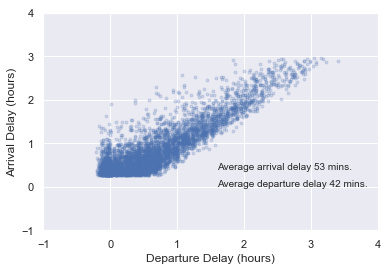

In [576]:
plt.plot(popular_route_del.DEP_DELAY / 60, popular_route_del.ARR_DELAY / 60, marker='.', linestyle='None', alpha = 0.2)
plt.xlim([-1, 4])
plt.ylim([-1, 4])
plt.xlabel('Departure Delay (hours)')
plt.ylabel('Arrival Delay (hours)')
plt.text(1.6, 0, f"Average departure delay {round((popular_route_del.DEP_DELAY).mean())} mins.")
plt.text(1.6, 0.4, f"Average arrival delay {round((popular_route_del.ARR_DELAY).mean())} mins.")
plt.show()

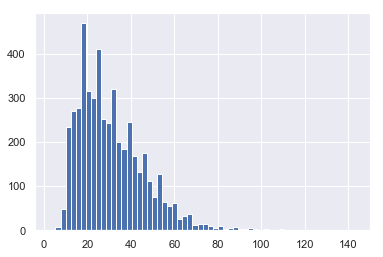

In [143]:
popular_route_del.TAXI_OUT.hist(bins=60)

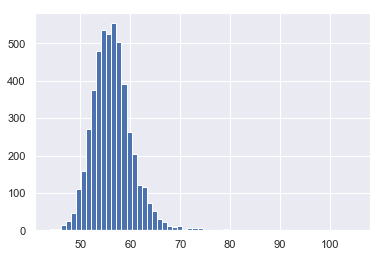

In [141]:
#The actual flight time looks like a normal distribution as it is most likely dependent on wind, 
#which is a natural occurance
popular_route_del.AIR_TIME.hist(bins=60)

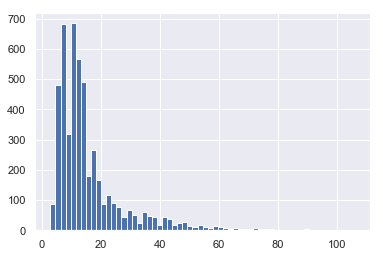

In [142]:
popular_route_del.TAXI_IN.hist(bins=60)

Text(0, 0.5, 'Departure Delay (minutes)')

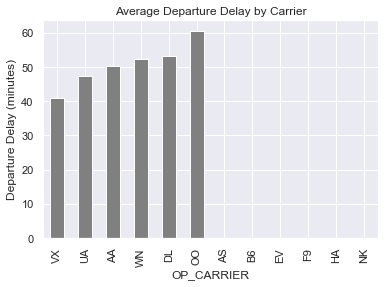

In [235]:
popular_route_del.groupby('OP_CARRIER').mean()['DEP_DELAY'].sort_values().plot(kind='bar', color='gray')
plt.title('Average Departure Delay by Carrier')
plt.ylabel('Departure Delay (minutes)')

Text(0, 0.5, 'Arrival Delay (minutes)')

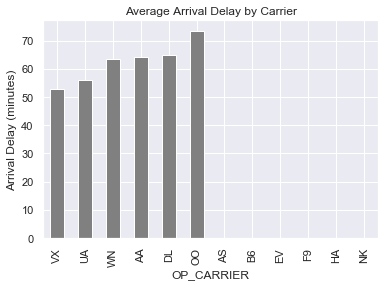

In [234]:
popular_route_del.groupby('OP_CARRIER').mean()['ARR_DELAY'].sort_values().plot(kind='bar', color='gray')
plt.title('Average Arrival Delay by Carrier')
plt.ylabel('Arrival Delay (minutes)')

## Second most popular route in United States (by number of flights) LAX to JFK

#### This example is a longer route

In [96]:
#Create a dataframe with the most popular route 
#This has all the flights, delayed and normal
#We need to split this into two dataframes: flights that are delayed and flights that are not
popular_route2 = optimized_df[(optimized_df.ORIGIN == 'LAX') & (optimized_df.DEST == 'JFK')]

In [97]:
popular_route2['DEP_TIME_SCALE'] = popular_route2.DEP_TIME.apply(time_to_float)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [98]:
popular_route2['ARR_TIME_SCALE'] = popular_route2.ARR_TIME.apply(time_to_float)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
#We need to split the popular_route dataframe into two: flights that are delayed and flights that are not
#Create a dataframe with only delayed flights of greater than 15 minutes for the most popular route
popular_route2_del = popular_route2[(popular_route2.ARR_DELAY > 15) & (popular_route2.ARR_DELAY < 240)]
#Create a dataframe with non-delayed flights
popular_route2_norm = popular_route2[popular_route2.ARR_DELAY <= 15]

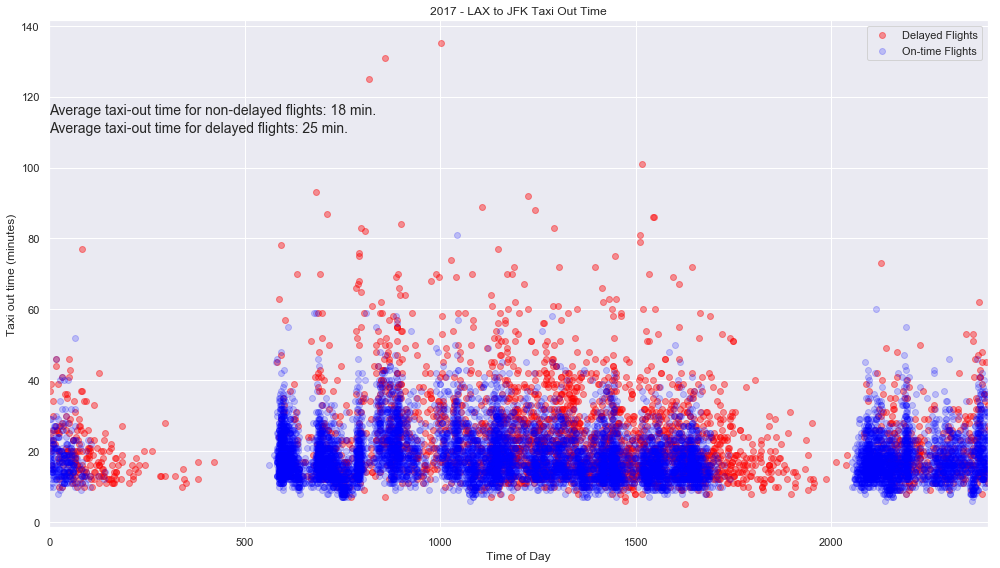

In [160]:
#The taxi out time at the destination for delayed and normal flights
x_normal = popular_route2_norm.DEP_TIME_SCALE
y_normal = popular_route2_norm.TAXI_OUT
x_delayed = popular_route2_del.DEP_TIME_SCALE
y_delayed = popular_route2_del.TAXI_OUT

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Taxi out time (minutes)')
ax.set_title('2017 - LAX to JFK Taxi Out Time')
plt.text(0, 115, f"Average taxi-out time for non-delayed flights: {round(popular_route2_norm.TAXI_OUT.mean())} min.", fontsize=14)
plt.text(0, 110, f"Average taxi-out time for delayed flights: {round(popular_route2_del.TAXI_OUT.mean())} min.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

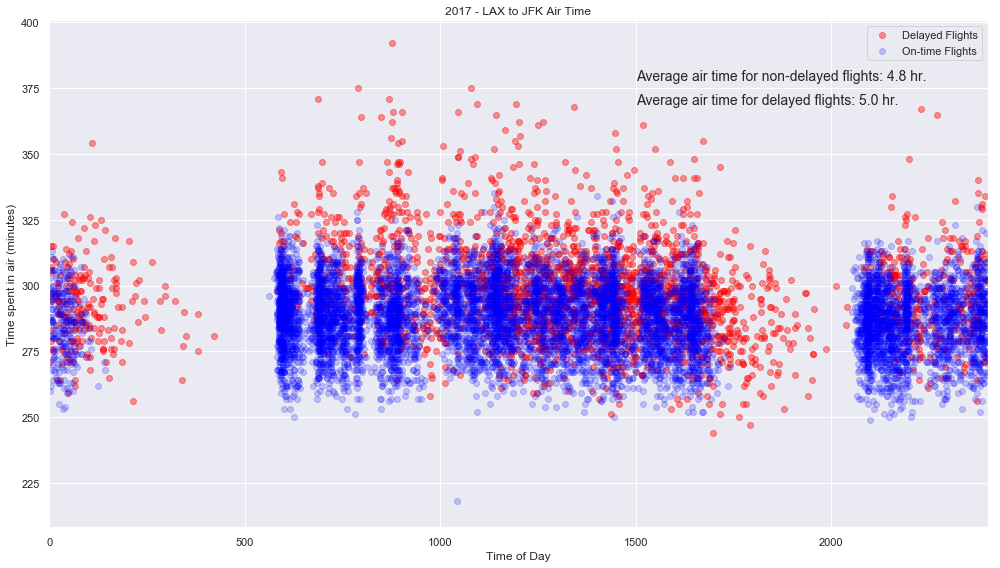

In [161]:
#Air time from LAX to JFK
x_normal = popular_route2_norm.DEP_TIME_SCALE
y_normal = popular_route2_norm.AIR_TIME
x_delayed = popular_route2_del.DEP_TIME_SCALE
y_delayed = popular_route2_del.AIR_TIME

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Time spent in air (minutes)')
ax.set_title('2017 - LAX to JFK Air Time')
plt.text(1500, 378, f"Average air time for non-delayed flights: {round(popular_route2_norm.AIR_TIME.mean()/60,1)} hr.", fontsize=14)
plt.text(1500, 369, f"Average air time for delayed flights: {round(popular_route2_del.AIR_TIME.mean()/60,1)} hr.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

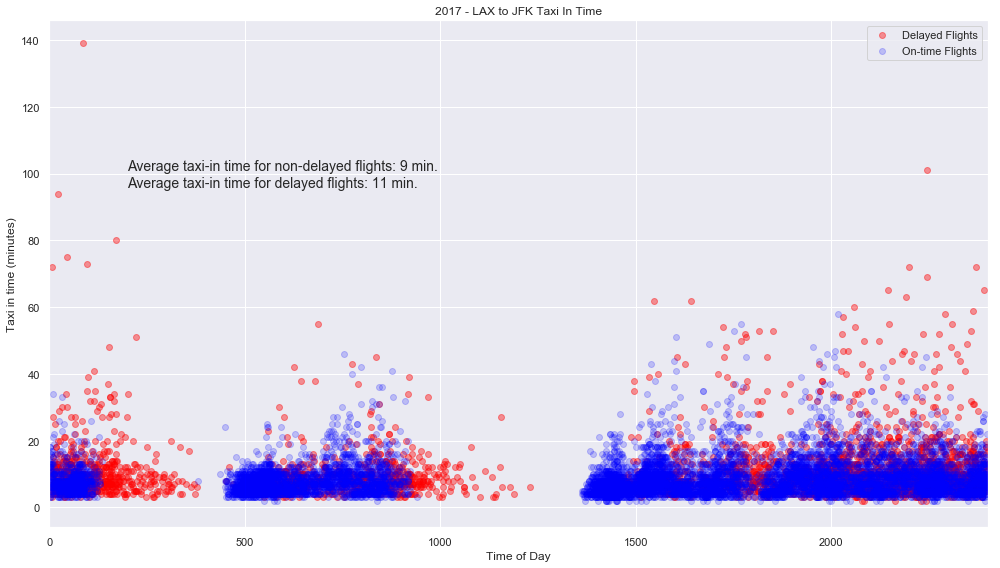

In [162]:
#And the taxi in time at the destination for delayed and normal flights
x_normal = popular_route2_norm.ARR_TIME_SCALE
y_normal = popular_route2_norm.TAXI_IN
x_delayed = popular_route2_del.ARR_TIME_SCALE
y_delayed = popular_route2_del.TAXI_IN

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Taxi in time (minutes)')
ax.set_title('2017 - LAX to JFK Taxi In Time')
plt.text(200, 101, f"Average taxi-in time for non-delayed flights: {round(popular_route2_norm.TAXI_IN.mean())} min.", fontsize=14)
plt.text(200, 96, f"Average taxi-in time for delayed flights: {round(popular_route2_del.TAXI_IN.mean())} min.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

## General questions about the airline data

In [163]:
#Which day of the week is worst for late flights
popular_route.groupby("DAY_OF_WEEK")['ARR_DELAY'].mean().sort_values(ascending=False)

DAY_OF_WEEK
5    23.044930
7    21.261126
4    20.176142
1    18.590115
3    12.199914
2     8.232688
6     3.984426
Name: ARR_DELAY, dtype: float32

In [489]:
#Which month of the year is worst for late flights
popular_route.groupby("MONTH")['ARR_DELAY'].mean().sort_values(ascending=False)

MONTH
5     32.686577
2     29.408236
1     27.444445
4     24.590086
3     21.338530
8     17.400730
10    10.787538
6     10.705138
9      7.500000
7      7.070796
11     4.052674
12    -1.862713
Name: ARR_DELAY, dtype: float32

In [627]:
#What is the average arrival delay per month broken down by airline
popular_route.groupby(["OP_CARRIER", "MONTH"])['ARR_DELAY'].mean().unstack()

MONTH,1,2,3,4,5,6,7,8,9,10,11,12
OP_CARRIER,,,,,,,,,,,,
AA,34.285713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DL,40.166668,NaN,NaN,22.095238,38.177631,0.168750,-0.852349,12.177143,-0.266234,7.968504,-6.272000,-17.103773
OO,36.721558,42.549549,29.042856,33.342106,32.416668,8.348214,5.232227,18.970711,10.259259,8.234568,7.035354,-3.409756
UA,20.692982,20.386503,13.625669,15.446686,23.190722,8.203297,0.247159,5.184652,2.024590,7.742500,-3.101299,-3.606322
VX,21.650177,22.657370,18.881756,23.447273,34.960575,18.080702,12.597270,20.163399,5.746269,11.253968,10.366101,2.304762
WN,30.185654,30.661837,22.801556,31.055084,42.095043,15.112069,16.949579,37.948498,20.853556,19.085020,10.420000,2.910506


In [494]:
#looks like AA only flew in January of 2017 from SFO to LAX, let's confirm
popular_route[popular_route["OP_CARRIER"] == 'AA']['MONTH'].unique()

array([1], dtype=uint64)

In [497]:
popular_route[popular_route["OP_CARRIER"] == 'UA']['MONTH'].unique()

array([ 3,  4,  5,  9, 10,  6,  7, 12,  1, 11,  8,  2], dtype=uint64)

# Possible Hypotheses

H0: On average, busy airports tend to have longer delays, Ha: Busy airports have the same delays as non busy airports

H0: On average, busy regions tend to have longer delays, Ha: Busy regions tend to have same delays as non busy aiprots

In [196]:
airport_loc.get('ATL')

(33.6367, 84.4281)

In [ ]:
#For regional calculation we'll set up a "radius" around the airport, for that we'll need a custom function
def radius(lat, long, miles):
    '''This function will return the absolute difference (in degrees) from the original location to the perimeter
    given the distance, and coordinates of the original location'''
    min_lat
    max_lat
    min_long
    max_lont
    return abs_lat, abs_long

In [ ]:
#how many degrees of longituted is 1 mile given that at the equator: 1 degree of longitude is 69.172 miles


In [31]:
#calculate the actual trip time using taxi times and actual flight time
trip_time = optimized_df.TAXI_OUT / 60 + optimized_df.ACTUAL_ELAPSED_TIME / 60 + optimized_df.TAXI_IN / 60 

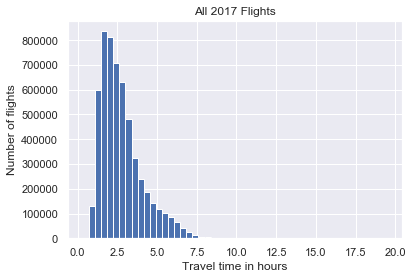

In [32]:
trip_time.hist(bins=50)
plt.xlabel('Travel time in hours')
plt.ylabel('Number of flights')
plt.title('All 2017 Flights')
plt.show()

#### Look at outliers for arrival delays

In [166]:
delay = optimized_df.ARR_DELAY / 60

Text(0.5, 1.0, '2017 All Arrival Delays')

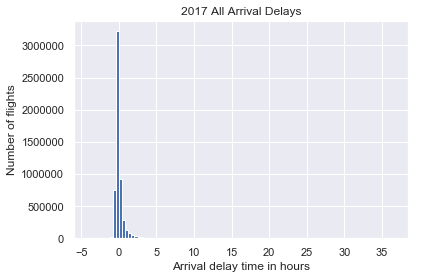

In [167]:
delay.hist(bins=100)
plt.xlabel('Arrival delay time in hours')
plt.ylabel('Number of flights')
plt.title('2017 All Arrival Delays')

In [168]:
#all delays
delays = optimized_df[optimized_df.ARR_DELAY > 0]

In [169]:
delays_15 = optimized_df[optimized_df.ARR_DELAY > 15]

In [170]:
delays_15.YEAR.value_counts() / optimized_df.YEAR.value_counts() * 100

2017    17.787185
Name: YEAR, dtype: float64

17% of all flights are delayed by more than 15 minutes.

In [171]:
#delays longer than 4 hrs
delay_4hr = optimized_df[optimized_df.ARR_DELAY / 60 >=4]

In [172]:
#delays more than 15mins and less than 4 hrs
delay_4hr_l = optimized_df[(optimized_df.ARR_DELAY / 60 < 4)& (optimized_df.ARR_DELAY > 15)]

In [173]:
delay_4hr.YEAR.value_counts() / delays.YEAR.value_counts() * 100

2017    1.453295
Name: YEAR, dtype: float64

Less than 1.5% of all DELAYED flights are delayed by more than 4 hours

Text(0.5, 1.0, '2017 Arrival Delay Longer Than 4 Hours')

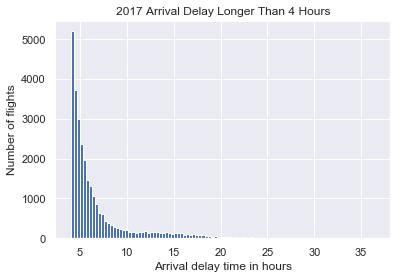

In [174]:
delay_4 = delay_4hr.ARR_DELAY / 60
delay_4.hist(bins=100)
plt.xlabel('Arrival delay time in hours')
plt.ylabel('Number of flights')
plt.title('2017 Arrival Delay Longer Than 4 Hours')

Text(0.5, 1.0, '2017 Arrival Delay Between 15min. and 4hrs.')

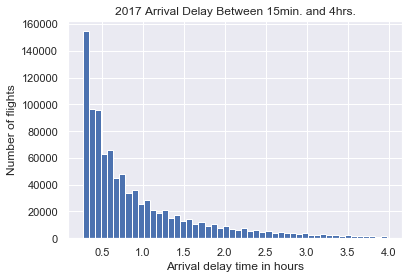

In [175]:
delay_4_arr = delay_4hr_l.ARR_DELAY / 60
delay_4_arr.hist(bins=50)
plt.xlabel('Arrival delay time in hours')
plt.ylabel('Number of flights')
plt.title('2017 Arrival Delay Between 15min. and 4hrs.')

<Figure size 1440x1440 with 0 Axes>

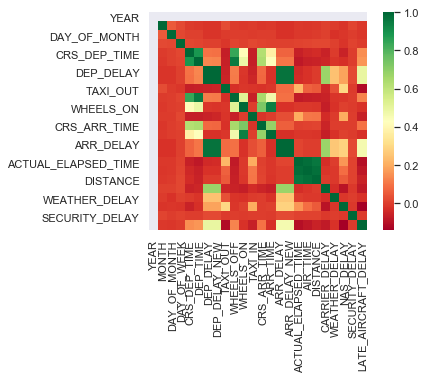

<Figure size 1440x1440 with 0 Axes>

In [176]:
sns.heatmap(delays.corr(), square=True, cmap='RdYlGn')
plt.figure(figsize=(20,20))

Text(0.5, 1.0, '2017 Delayed Flights by Carrier')

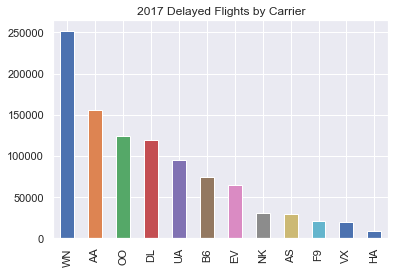

In [177]:
delays_15.OP_CARRIER.value_counts().plot(kind='bar')
plt.title('2017 Delayed Flights by Carrier')

Text(0.5, 1.0, 'All 2017 Flights by Carrier')

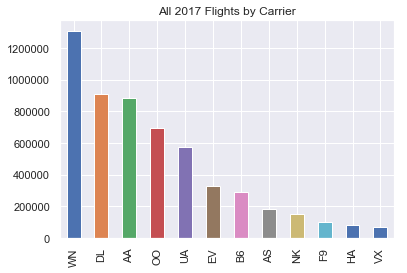

In [556]:
optimized_df.OP_CARRIER.value_counts().plot(kind='bar')
plt.title('All 2017 Flights by Carrier')

In [191]:
delays.ORIGIN.value_counts().head()

ATL    116469
ORD     95990
LAX     84397
DEN     79519
SFO     72993
Name: ORIGIN, dtype: int64

In [558]:
optimized_df.ORIGIN.value_counts().head()

ATL    358537
ORD    262074
DEN    221148
LAX    211730
DFW    178967
Name: ORIGIN, dtype: int64

In [559]:
delays.groupby(['OP_CARRIER', 'MONTH']).size().unstack()

MONTH,1,2,3,4,5,6,7,8,9,10,11,12
OP_CARRIER,,,,,,,,,,,,
AA,27275,20011,28448,27059,27688,32924,32670,30993,20240,24606,18840,25807
AS,5732,5050,6515,6115,6124,6177,5597,6248,4998,4833,4951,4936
B6,9546,8385,10108,9676,10782,12606,12414,11495,7478,7345,6031,10165
DL,21320,13575,19464,23580,25832,25662,25375,21609,16211,19869,12194,18496
EV,13213,8193,11982,10339,10397,10963,10033,8889,6279,7260,5131,7267
F9,3357,2016,2693,2781,3407,3888,3721,3341,2166,2990,2517,3683
HA,2566,2954,2913,2405,2472,2638,2532,2279,1594,2428,2340,3128
NK,4915,3610,4803,4384,5106,5603,5218,4742,2969,3020,2661,4389
OO,20692,14958,20764,18913,19019,20373,22696,24152,17067,21518,16719,22497


Text(0.5, 1.0, 'Delayed Flights by Carrier')

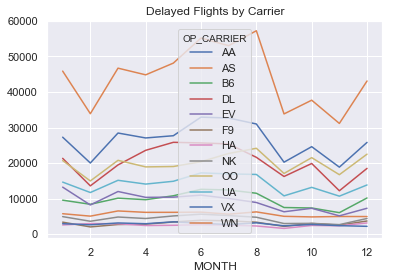

In [560]:
delays.groupby(['OP_CARRIER', 'MONTH']).size().unstack('OP_CARRIER').plot()
plt.title('Delayed Flights by Carrier')

In [181]:
optimized_df.groupby(['OP_CARRIER', 'MONTH']).size().unstack('OP_CARRIER')

OP_CARRIER,AA,AS,B6,DL,EV,F9,HA,NK,OO,UA,VX,WN
MONTH,,,,,,,,,,,,
1,71947,14386,23968,68842,33732,7579,6251,12110,47994,42056,5568,105212
2,66217,12994,21449,64862,29695,6645,5771,11228,45605,39556,4920,94283
3,76755,15275,24926,78494,33870,7650,6566,12542,56800,47766,5661,112849
4,72769,15159,24776,73718,29776,7764,6454,12298,55174,45423,5497,111168
5,76669,15990,24793,80511,30025,8585,6775,12553,58056,49229,5779,112536
6,75594,16252,24637,80746,29378,8880,7057,12912,60818,51623,5891,113793
7,77567,16919,25678,83327,28243,9543,7281,13764,63606,52906,6107,116818
8,78039,16634,25534,84451,26764,9114,7248,13740,64905,53051,6100,112583
9,68620,14796,21690,73675,22988,8374,6546,11560,59289,47352,5744,101959


Text(0.5, 1.0, 'All Flights by Carrier')

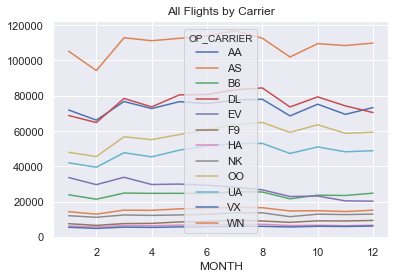

In [561]:
optimized_df.groupby(['OP_CARRIER', 'MONTH']).size().unstack('OP_CARRIER').plot()
plt.title('All Flights by Carrier')

In [186]:
#Let's break the above data down by airline. Most flights are by SouthWest
SouthWest = optimized_df[optimized_df.OP_CARRIER == 'WN']
SouthWest_del = delays[delays.OP_CARRIER == 'WN']

In [184]:
SouthWest.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,...,ARR_DELAY,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
373453,2017,3,1,3,2017-03-01,WN,ABQ,"Albuquerque, NM",NM,BWI,...,-14.0,0.0,207.0,186.0,1670.0,NaN,NaN,NaN,NaN,NaN
373454,2017,3,1,3,2017-03-01,WN,ABQ,"Albuquerque, NM",NM,DAL,...,-17.0,0.0,83.0,71.0,580.0,NaN,NaN,NaN,NaN,NaN
373455,2017,3,1,3,2017-03-01,WN,ABQ,"Albuquerque, NM",NM,DAL,...,-23.0,0.0,85.0,72.0,580.0,NaN,NaN,NaN,NaN,NaN
373456,2017,3,1,3,2017-03-01,WN,ABQ,"Albuquerque, NM",NM,DAL,...,-15.0,0.0,87.0,73.0,580.0,NaN,NaN,NaN,NaN,NaN
373457,2017,3,1,3,2017-03-01,WN,ABQ,"Albuquerque, NM",NM,DAL,...,-18.0,0.0,84.0,72.0,580.0,NaN,NaN,NaN,NaN,NaN


In [187]:
SouthWest_del.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,...,ARR_DELAY,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
373462,2017,3,1,3,2017-03-01,WN,ABQ,"Albuquerque, NM",NM,HOU,...,18.0,18.0,122.0,101.0,759.0,0.0,0.0,7.0,0.0,11.0
373464,2017,3,1,3,2017-03-01,WN,ABQ,"Albuquerque, NM",NM,HOU,...,35.0,35.0,107.0,95.0,759.0,3.0,0.0,0.0,0.0,32.0
373465,2017,3,1,3,2017-03-01,WN,ABQ,"Albuquerque, NM",NM,LAS,...,28.0,28.0,103.0,83.0,486.0,0.0,0.0,13.0,0.0,15.0
373468,2017,3,1,3,2017-03-01,WN,ABQ,"Albuquerque, NM",NM,LAS,...,17.0,17.0,114.0,75.0,486.0,0.0,0.0,17.0,0.0,0.0
373470,2017,3,1,3,2017-03-01,WN,ABQ,"Albuquerque, NM",NM,LAX,...,8.0,8.0,128.0,96.0,677.0,NaN,NaN,NaN,NaN,NaN


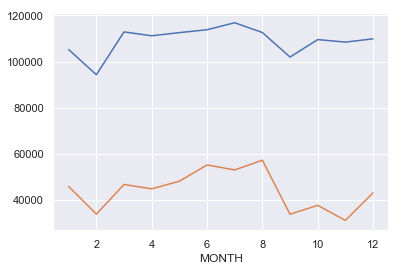

In [190]:
SouthWest.groupby('MONTH').size().plot()
SouthWest_del.groupby('MONTH').size().plot()

In [562]:
carrier = delays[(delays["CARRIER_DELAY"] > 0.5)]
weather = delays[delays.WEATHER_DELAY > 0.5]
NAS = delays[delays.NAS_DELAY > 0.5]
late_aircraft = delays[delays.LATE_AIRCRAFT_DELAY > 0.5]
carrier = delays[delays.SECURITY_DELAY > 0.5]

In [564]:
bay_area = delays[(delays.ORIGIN == 'SJC') | (delays.ORIGIN == 'SFO') | (delays.ORIGIN == 'OAK')]

In [565]:
bay_area_to_nyc = bay_area[(bay_area.DEST == 'JFK') | (bay_area.DEST == 'EWR') | (bay_area.DEST == 'LGA')]

In [566]:
bay_area_to_nyc.groupby('OP_CARRIER').size()

OP_CARRIER
AA     622
AS     121
B6     987
DL     831
EV       0
F9       0
HA       0
NK       0
OO       0
UA    2098
VX    1558
WN      49
dtype: int64